# Analise e Previsão de Acidentes de Transito Fatais em Rodovias Federais Brasileiras

Rayron Ferreira

05/03/2025

### Motivação

- impacto economico
- impacto social
- quanto custa por ano os acidentes ?
- qual o impacto com acidentes fatais ?
- reduzir o numero de acidentes de transito e esses impactos
- mitigar/evitar condicoes nas estradas que causam acidentes fatais
- previsao de acidente e gravidade do acidente
- podemos identificar os padroes de como os acidentes fatais ocorrem e os principais fatores?
- alocar melhor os recursos financeiros e humanos nas rodovias federais buscando evitar acidentes fatais

### Objetivos


### Analise

### Palavras-chave

### Sobre o Dataset

### Agradecimentos e Colaborações  

### Referencias

## Visualização e pre-processamento dos dados

In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import seaborn as sns
import os
from scipy.stats import boxcox
# from pymongo import MongoClient
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Classificação das Variáveis

**Atributos de Identificação**
* **id**: Identificador do acidente.
* **pesid**: Identificador da pessoa envolvida.
* **id_veiculo**: Identificador do veículo envolvido.

**Atributos de Período do Dia**
* **data_inversa**: Data da ocorrência.
* **dia_semana**: Dia da semana da ocorrência.
* **horario**: Horário da ocorrência.
* **fase_dia**: Fase do dia no momento do acidente.

**Atributos de Endereço**
* **uf**: Unidade da Federação.
* **br**: Identificador da BR.
* **km**: Quilômetro do acidente.
* **municipio**: Nome do município.
* **latitude**: Latitude do local do acidente.
* **longitude**: Longitude do local do acidente.
* **regional**: Superintendência regional da PRF.
* **delegacia**: Delegacia da PRF.
* **uop**: Unidade operacional da PRF.

**Atributos de Tráfego**
* **sentido_via**: Sentido da via.
* **tipo_pista**: Tipo de pista.
* **tracado_via**: Descrição do traçado da via.
* **uso_solo**: Características do local do acidente (urbano/rural).

**Atributos Climáticos**
* **condição_meteorologica**: Condição meteorológica no momento do acidente.

**Atributos de Causa e Tipo de Acidente**
* **causa_principal**: Causa principal do acidente.
* **causa_acidente**: Causa presumível do acidente.
* **ordem_tipo_acidente**: Sequência de eventos no acidente.
* **tipo_acidente**: Tipo de acidente.
* **classificação_acidente**: Gravidade do acidente.

**Atributos de Veículo**
* **tipo_veiculo**: Tipo de veículo.
* **marca**: Marca do veículo.
* **ano_fabricacao_veiculo**: Ano de fabricação do veículo.

**Atributos de Pessoas Envolvidas**
* **tipo_envolvido**: Tipo de envolvido no acidente.
* **estado_fisico**: Condição física do envolvido.
* **idade**: Idade do envolvido.
* **sexo**: Sexo do envolvido.

**Atributos de Vítimas**
* **ilesos**: Identifica se o envolvido foi ileso.
* **feridos_leves**: Identifica se o envolvido foi ferido leve.
* **feridos_graves**: Identifica se o envolvido foi ferido grave.
* **mortos**: Identifica se o envolvido foi morto.


### Leitura dos Dados

In [ ]:
# ler todos os datasets csv
folder_path = "data"
dfs = []

def detect_delimiter(file_path):
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        first_line = file.readline()
        if ',' in first_line and ';' not in first_line:
            return ','
        elif ';' in first_line and ',' not in first_line:
            return ';'
        else:
            raise ValueError("Delimitador não identificado no arquivo: " + file_path)

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    if file_name.endswith('.csv'):
        try:
            delimiter = detect_delimiter(file_path)
            new_df = pd.read_csv(file_path, delimiter=delimiter, encoding='ISO-8859-1', low_memory=False)
            dfs.append(new_df)
        except Exception as e:
            print(f"Erro ao processar o arquivo {file_name}: {e}")

df = pd.concat(dfs, ignore_index=True)

In [ ]:
# salvar dataset combinado

df.to_csv("acidentes-2013-2024.csv", index=False)

In [2]:
df_prf = pd.read_excel('data/dataset10anos.xlsx')

In [ ]:
client = MongoClient('mongodb://localhost:27017/')
db = client['data_science']
collection = db['prf']

documents = collection.find()  

df_prf = pd.DataFrame(documents)

df_prf.describe()

In [ ]:
df_prf.info()

In [4]:
df_prf.to_excel('data/dataset10anos.xlsx', index=False, engine='openpyxl')


### Pre Processamento dos Dados

In [ ]:
# checando variáveis categóricas
variaveis_categoricas = ['municipio', 'uf','causa_acidente','tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'uso_solo', 'estado_fisico', 'tipo_envolvido', 'marca', 'tipo_pista' ]

for variavel in variaveis_categoricas:
  print(variavel, df_prf[variavel].unique())

In [ ]:
# remover variáveis que nao serão utilizadas na analise, pois nao fornecem nenhuma descricao que auxilie na previsão de acidentes
# como o id do acidente gerado pelo dataset (id)
# id da pessoa (pesid)
# e também os dados de qual unidade da PRF que realizou o registro do acidente (regional, delegacia e uop)
# _id gerado pelo mongo

df_prf = df_prf.drop(['regional','delegacia','uop','id', 'pesid', '_id', 'nacionalidade', 'naturalidade'], axis=1)
df_prf = df_prf.dropna(subset=['ilesos', "feridos_leves", "feridos_graves", "mortos"])

In [4]:
def calcular_sentido_via(row):
    if row['sentido_via'] == 'decrescente':
        return 0
    elif row['sentido_via'] == 'crescente':
        return 1
    
def calcular_tipo_pista(row):
    if row['tipo_pista'] == 'simples':
        return 1
    elif row['tipo_pista'] == 'dupla':
        return 2
    elif row['tipo_pista'] == 'multipla':
        return 3

def calcular_uso_solo(row):
    if row['uso_solo'] == 'nao':
        return 0
    elif row['uso_solo'] == 'sim':
        return 1
    
def calcular_sexo(row):
    if row['sexo'] == 'masculino':
        return 0
    elif row['sexo'] == 'feminino':
        return 1
    
def calcular_gravidade(row):
    if row['ilesos'] == 1:
        return 1
    elif row['feridos_leves'] == 1:
        return 2
    elif row['feridos_graves'] == 1:
        return 3
    elif row['mortos'] == 1:
        return 4
    else:
        return 0
    
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def map_regiao(uf):
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao
    return 'Outros'
    
def is_within_brazil(lat, lon):
    return -33.7422 <= lat <= 5.2718 and -73.989 <= lon <= -34.793

def resample(dat, col, n):
    return pd.concat([dat[dat[col]==1].sample(n, replace = True),
                   dat[dat[col]==0].sample(n)], axis=0)

In [5]:
print('Valores únicos ilesos')
for ileso in df_prf["ilesos"].unique():
    print(ileso)

print('Valores únicos feridos_leves')
for ferido_leve in df_prf["feridos_leves"].unique():
    print(ferido_leve)

print('Valores únicos feridos_graves')
for ferido_grave in df_prf["feridos_graves"].unique():
    print(ferido_grave)

print('Valores únicos mortos')
for morto in df_prf["mortos"].unique():
    print(morto)

Valores únicos ilesos
1
0
Valores únicos feridos_leves
0
1
Valores únicos feridos_graves
0
1
Valores únicos mortos
0
1


In [6]:
# definir gravidade do acidente
# **Atributos de Vítimas**
# * **ilesos**: Identifica se o envolvido foi ileso. nível 1
# * **feridos_leves**: Identifica se o envolvido foi ferido leve. nível 2
# * **feridos_graves**: Identifica se o envolvido foi ferido grave. nível 3
# * **mortos**: Identifica se o envolvido foi morto. nível 4

df_prf['gravidade'] = df_prf.apply(calcular_gravidade, axis=1)
df_prf = df_prf[df_prf['gravidade'] != 0]

In [7]:
print('Valores únicos gravidade')
for gravidade in df_prf["gravidade"].unique():
    print(gravidade)

Valores únicos gravidade
1
2
4
3


In [8]:
# transformar campos categóricos de ate 3 categorias em numéricos
df_prf['sentido_via'] = df_prf.apply(calcular_sentido_via, axis=1)
df_prf['tipo_pista'] = df_prf.apply(calcular_tipo_pista, axis=1)
df_prf['uso_solo'] = df_prf.apply(calcular_uso_solo, axis=1)
df_prf['sexo'] = df_prf.apply(calcular_sexo, axis=1)

df_prf['km'] = df_prf['km'].str.replace(',', '').astype(float)
df_prf['ano_fabricacao_veiculo'] = df_prf['ano_fabricacao_veiculo'].astype(int)

# separar as regiões baseado no campo uf
df_prf['regiao'] = df_prf['uf'].apply(map_regiao)

In [9]:
# definindo features booleanas para as condições climáticas

df_prf["Céu Claro"] = np.where(df_prf["condicao_metereologica"].str.contains("ceu_claro", case=False, na = False), True, False)
df_prf["Garoa/Chuvisco"] = np.where(df_prf["condicao_metereologica"].str.contains("garoa_chuvisco", case=False, na = False), True, False)
df_prf["Nublado"] = np.where(df_prf["condicao_metereologica"].str.contains("nublado", case=False, na = False), True, False)
df_prf["Sol"] = np.where(df_prf["condicao_metereologica"].str.contains("sol", case=False, na = False), True, False)
df_prf["Chuva"] = np.where(df_prf["condicao_metereologica"].str.contains("chuva", case=False, na = False), True, False)
df_prf["Nevoeiro/Neblina"] = np.where(df_prf["condicao_metereologica"].str.contains("nevoeiro_neblina", case=False, na = False), True, False)
df_prf["Vento"] = np.where(df_prf["condicao_metereologica"].str.contains("vento", case=False, na = False), True, False)
df_prf["Granizo"] = np.where(df_prf["condicao_metereologica"].str.contains("granizo", case=False, na = False), True, False)
df_prf["Neve"] = np.where(df_prf["condicao_metereologica"].str.contains("neve", case=False, na = False), True, False)

# removendo os campos false onde nao possui determinada condição e removendo o campo "condicao_metereologica"
# assim temos variáveis booleanas para as condições metereologicas

condicoes_climaticas = [
  "Céu Claro",
  "Garoa/Chuvisco",
  "Nublado",
  "Sol",
  "Chuva",
  "Nevoeiro/Neblina",
  "Vento",
  "Granizo",
  "Neve",
]

for condicao in condicoes_climaticas:
  df_prf.loc[df_prf["condicao_metereologica"].isnull(), condicao] = df_prf.loc[df_prf["condicao_metereologica"].isnull(), "condicao_metereologica"]
  df_prf[condicao] = df_prf[condicao].astype("bool")

df_prf.loc[:, ["condicao_metereologica"] + condicoes_climaticas]

df_prf = df_prf.drop(["condicao_metereologica"], axis=1)

C:\Users\Rayron\AppData\Local\Temp\ipykernel_10508\1169004356.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_prf.loc[df_prf["condicao_metereologica"].isnull(), condicao] = df_prf.loc[df_prf["condicao_metereologica"].isnull(), "condicao_metereologica"]
C:\Users\Rayron\AppData\Local\Temp\ipykernel_10508\1169004356.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_prf.loc[df_prf["condicao_metereologica"].isnull(), condicao] = df_prf.loc[df_prf["condicao_metereologica"].isnull(), "condicao_metereologica"]
C:\Users\Rayron\AppData\Local\Temp\ipykernel_10508\1169004356.py:29: FutureWarning: Setting an item of incompatible dtype is dep

In [10]:
# transformar campo horário para datetime

df_prf["data_horario"] = pd.to_datetime(df_prf["data_inversa"] + " " + df_prf["horario"], errors='coerce')

# definindo colunas de temporais
df_prf["Ano"] = df_prf["data_horario"].dt.year
df_prf["Mes"] = df_prf["data_horario"].dt.month
df_prf["Dia"] = df_prf["data_horario"].dt.day
df_prf["Hora"] = df_prf["data_horario"].dt.hour
df_prf["Minuto"] = df_prf["data_horario"].dt.minute
df_prf["Dia da Semana"] = df_prf["data_horario"].dt.weekday

colunas_temporais = ["horario", "Ano", "Mes", "Dia da Semana", "Dia", "Hora", "Minuto"]

df_prf[colunas_temporais].head(5)

,horario,Ano,Mes,Dia da Semana,Dia,Hora,Minuto
0,01:45:00,2017,1,6,1,1,45
1,01:00:00,2017,1,6,1,1,0
2,04:40:00,2017,1,6,1,4,40
3,07:40:00,2017,1,6,1,7,40
4,10:35:00,2017,1,6,1,10,35


In [11]:
# transformação e filtro das coordenadas
df_prf['longitude'] = df_prf['longitude'].str.replace(",", ".").astype(float).round(6)
df_prf['latitude'] = df_prf['latitude'].str.replace(",", ".").astype(float).round(6)

df_prf = df_prf[df_prf.apply(lambda row: is_within_brazil(row['latitude'], row['longitude']), axis=1)]

In [12]:
df_gravidade4 = df_prf
df_gravidade4['gravidade4'] = 0
df_gravidade4.loc[df_gravidade4['gravidade'] == 4, 'gravidade4'] = 1
df_gravidade4 = df_gravidade4.drop(['gravidade'], axis = 1)

df_gravidade4.gravidade4.value_counts()

gravidade4
0    948751
1     29027
Name: count, dtype: int64

### Visualização de Dados

<Axes: title={'center': 'Gravidade por tipo de veiculo'}, xlabel='tipo_veiculo'>

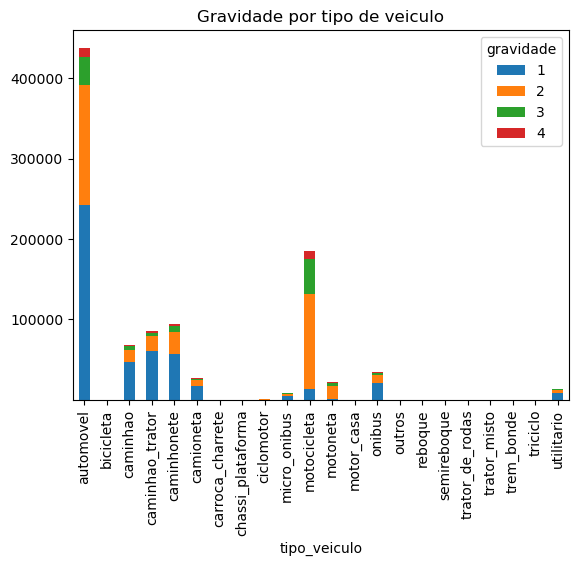

In [13]:
df_prf_gravidade = df_prf.groupby(['gravidade','tipo_veiculo']).size().reset_index().pivot(\
    columns='gravidade', index='tipo_veiculo', values=0)
df_prf_gravidade.plot(kind='bar', stacked=True, title='Gravidade por tipo de veiculo')

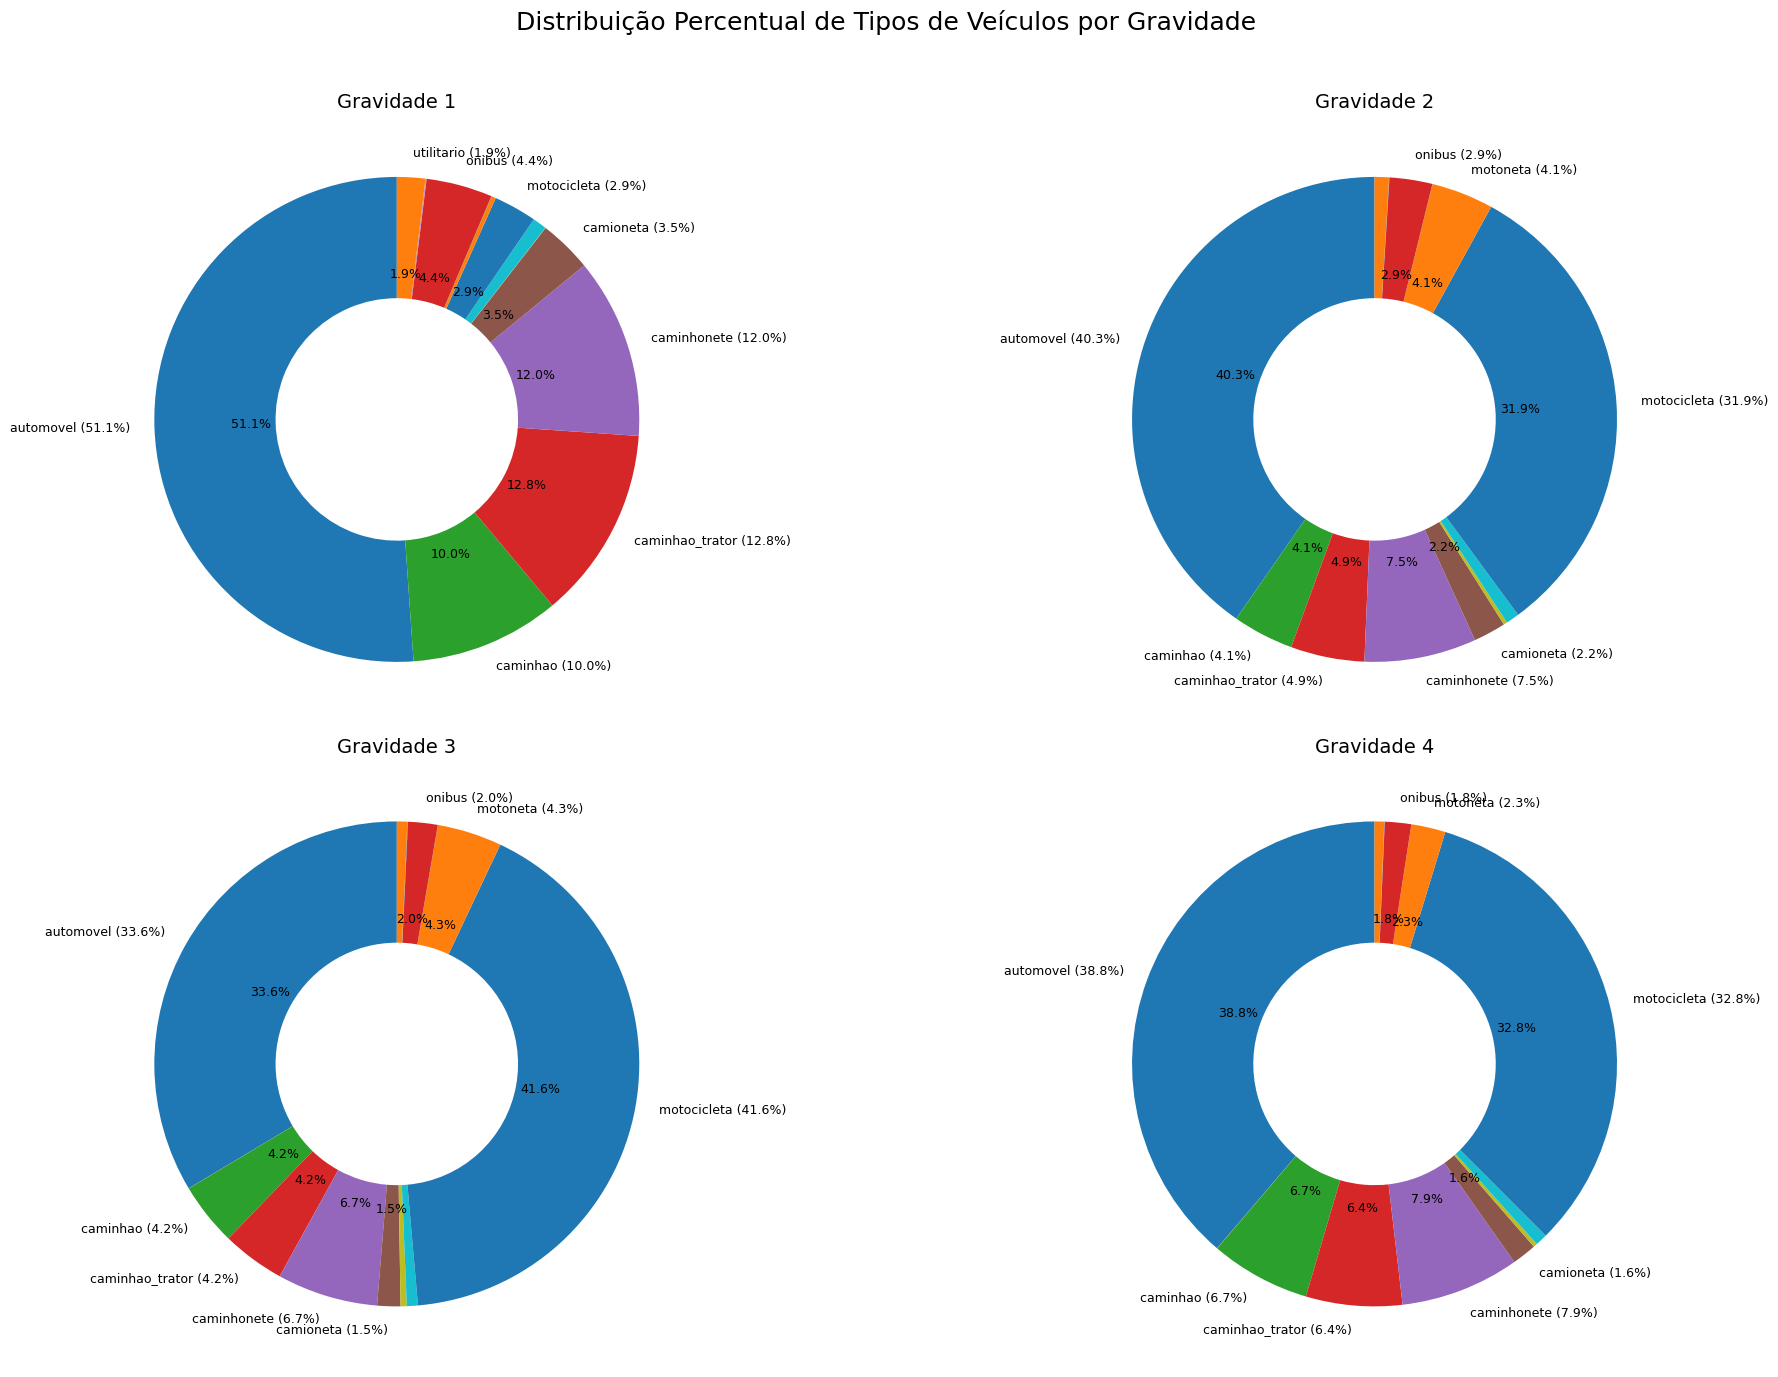

In [14]:
#df = pd.DataFrame(df_prf_gravidade).set_index('gravidade')
# Preenchendo valores ausentes com 0
df = df_prf_gravidade.fillna(0)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Aumentar o tamanho da figura
axes = axes.ravel()

for idx, gravidade in enumerate(df.columns):
    # Calcular os percentuais
    total = df[gravidade].sum()
    percentuais = (df[gravidade] / total) * 100
    
    # Filtro para rótulos menores que 1%
    labels = [f'{label} ({pct:.1f}%)' if pct >= 1 else '' for label, pct in zip(df.index, percentuais)]
    
    # Plotar o gráfico de rosquinha
    wedges, texts, autotexts = axes[idx].pie(
        percentuais, 
        labels=labels, 
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 1 else '',  # Apenas percentuais >= 1%
        startangle=90, 
        wedgeprops={'width': 0.5},
        textprops={'fontsize': 10},  # Ajustar fonte
    )
    
    # Ajustar aparência dos textos
    for text in texts:
        text.set_fontsize(9)
        text.set_color('black')
    for autotext in autotexts:
        autotext.set_fontsize(9)
        autotext.set_color('black')
    
    axes[idx].set_title(f'Gravidade {gravidade}', fontsize=14)

# Ajustar o layout geral
plt.suptitle('Distribuição Percentual de Tipos de Veículos por Gravidade', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [15]:
df_prf_balanceado = resample(df_gravidade4, 'gravidade4', 50000)

print('Dataset balanceado:', df_prf_balanceado.gravidade4.value_counts())

Dataset balanceado: gravidade4
1    50000
0    50000
Name: count, dtype: int64


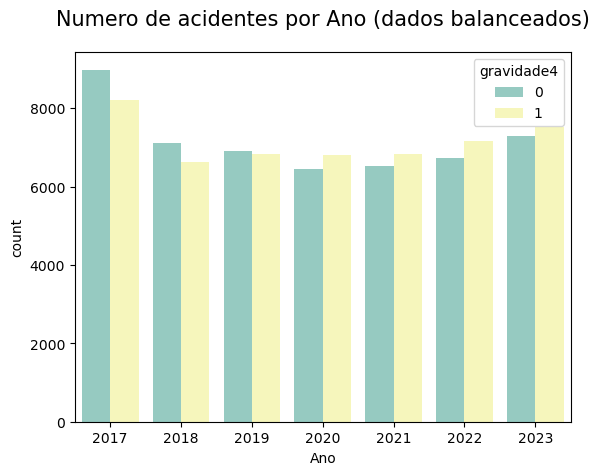

In [16]:
# Ano
df_prf_balanceado_ordenado = df_prf_balanceado.sort_values(by=['Ano', 'Mes', 'Dia da Semana'])
df_prf_balanceado_ordenado.Ano = df_prf_balanceado_ordenado.Ano.astype(str)

sns.countplot(x='Ano', hue='gravidade4', data=df_prf_balanceado_ordenado ,palette="Set3")
plt.title('Numero de acidentes por Ano (dados balanceados)', size=15, y=1.05)
plt.show()

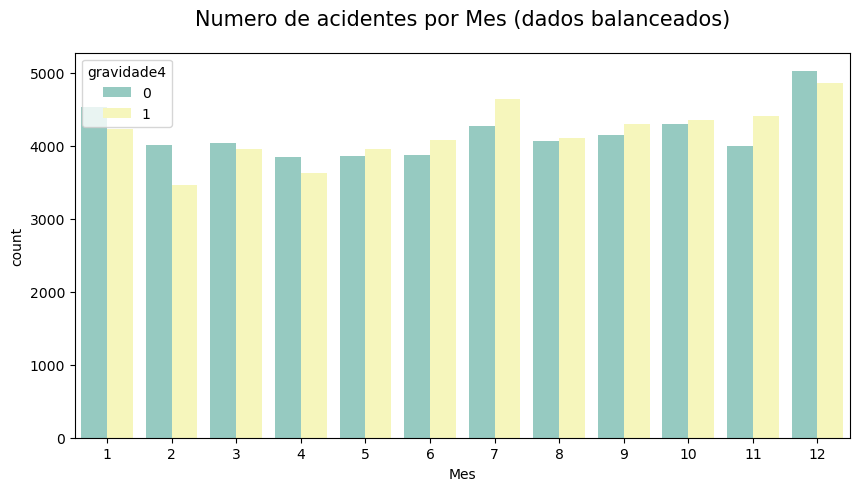

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='Mes', hue='gravidade4', data=df_prf_balanceado_ordenado ,palette="Set3")
plt.title('Numero de acidentes por Mes (dados balanceados)', size=15, y=1.05)
plt.show()

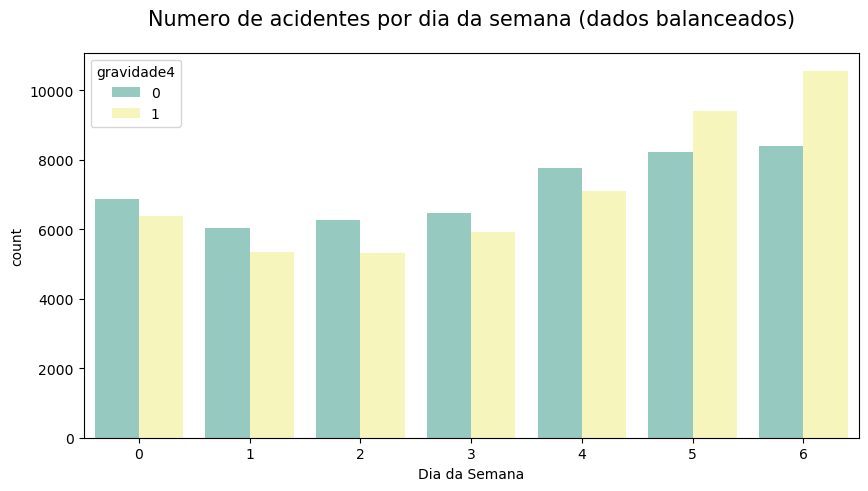

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='Dia da Semana', hue='gravidade4', data=df_prf_balanceado_ordenado ,palette="Set3")
plt.title('Numero de acidentes por dia da semana (dados balanceados)', size=15, y=1.05)
plt.show()

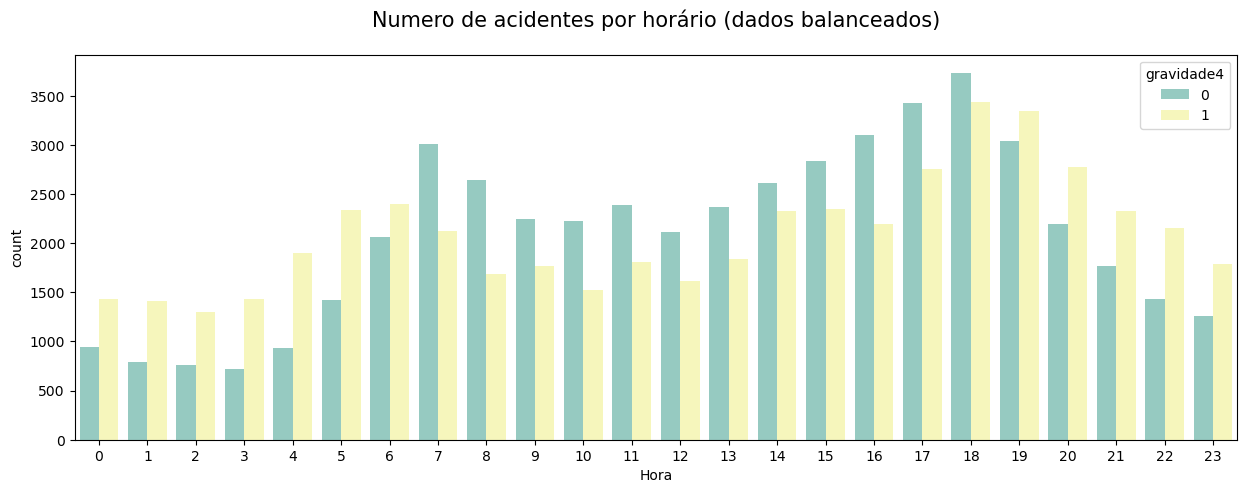

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(x='Hora', hue='gravidade4', data=df_prf_balanceado_ordenado ,palette="Set3")
plt.title('Numero de acidentes por horário (dados balanceados)', size=15, y=1.05)
plt.show()

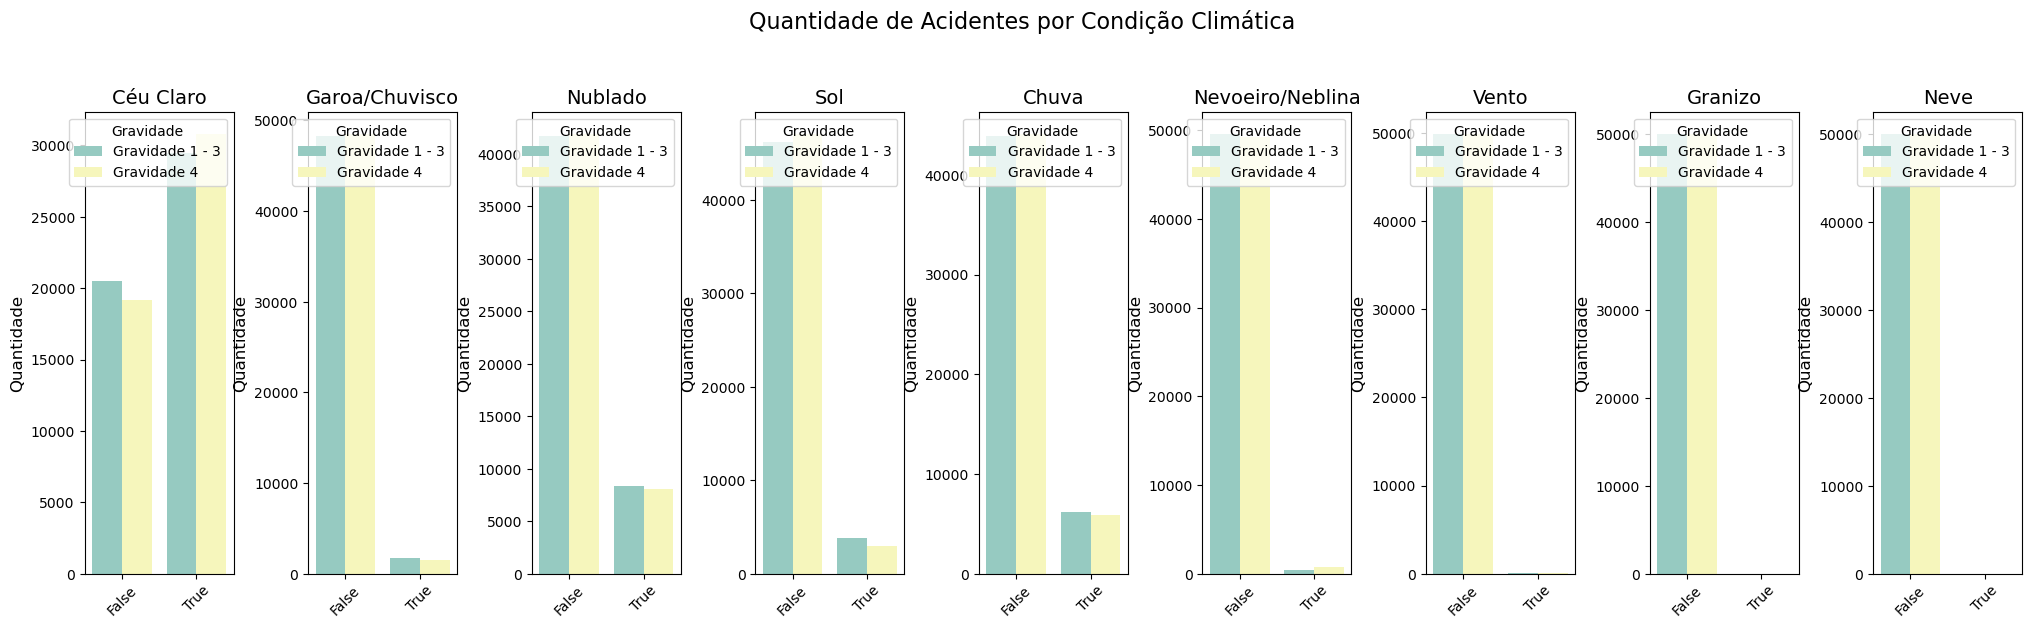

In [20]:
period_features = ['Céu Claro', 'Garoa/Chuvisco', 'Nublado', 'Sol', 'Chuva', 'Nevoeiro/Neblina', 'Vento', 'Granizo', 'Neve']

fig, axs = plt.subplots(nrows=1, ncols=len(period_features), figsize=(25, 6))
plt.subplots_adjust(wspace=0.5)

for i, feature in enumerate(period_features):
    sns.countplot(
        x=feature, 
        hue='gravidade4', 
        data=df_prf_balanceado, 
        palette="Set3", 
        ax=axs[i]
    )
    axs[i].set_title(feature, fontsize=14)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Quantidade', fontsize=12)
    axs[i].legend(title='Gravidade', labels=['Gravidade 1 - 3', 'Gravidade 4'], fontsize=10)
    axs[i].tick_params(axis='x', rotation=45, labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

# Título geral do gráfico
fig.suptitle('Quantidade de Acidentes por Condição Climática', fontsize=16, y=1.05)

# Exibir o gráfico
plt.show()

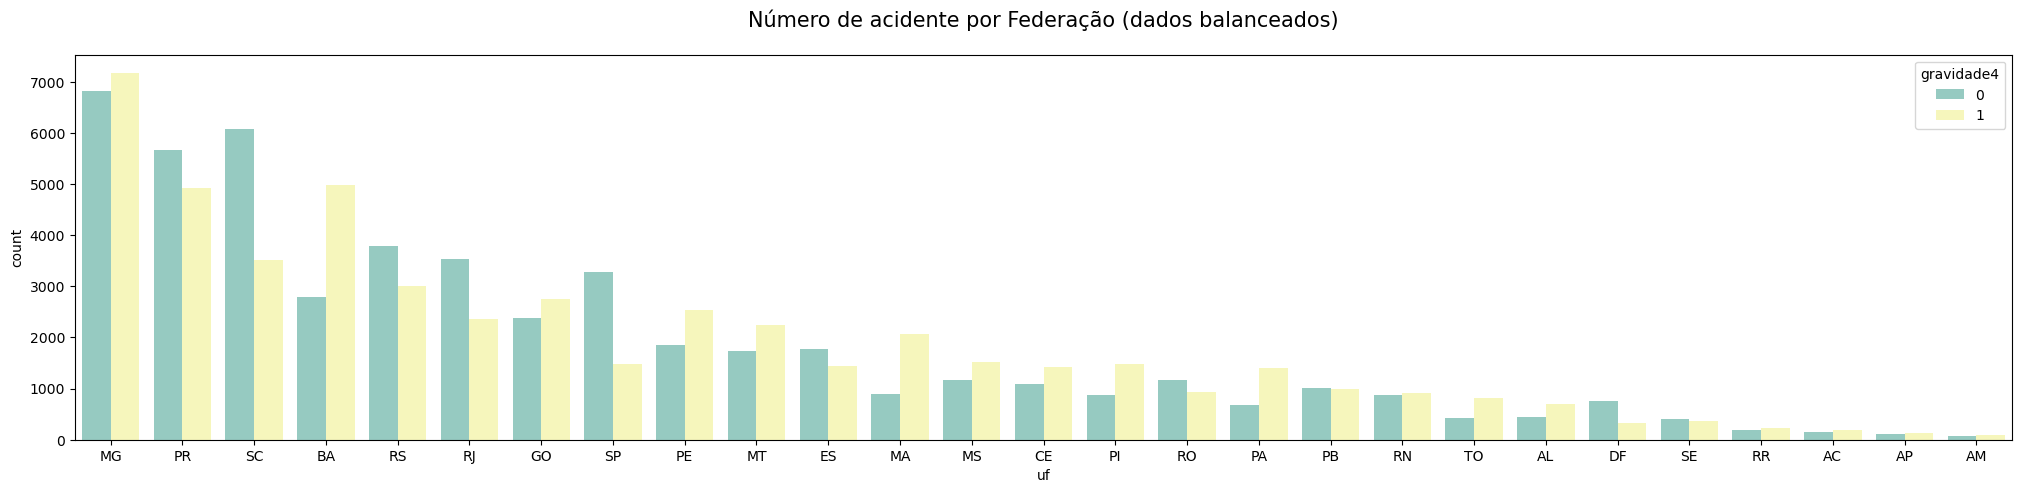

In [21]:
plt.figure(figsize=(25,5))
chart = sns.countplot(x='uf', hue='gravidade4', 
                      data=df_prf_balanceado_ordenado ,palette="Set3", order=df_prf_balanceado_ordenado['uf'].value_counts().index)
plt.title("Número de acidente por Federação (dados balanceados)", size=15, y=1.05)
plt.show()

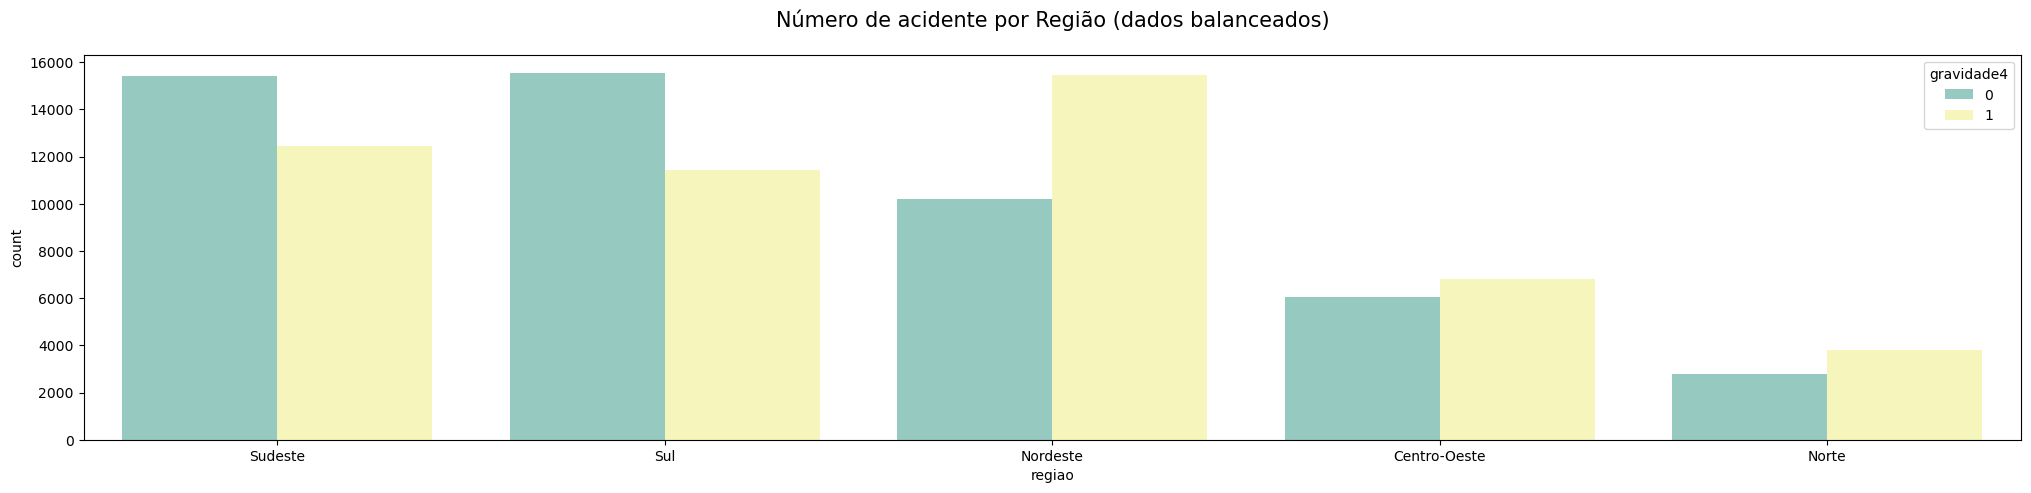

In [22]:
plt.figure(figsize=(25,5))
chart = sns.countplot(x='regiao', hue='gravidade4', 
                      data=df_prf_balanceado_ordenado ,palette="Set3", order=df_prf_balanceado_ordenado['regiao'].value_counts().index)
plt.title("Número de acidente por Região (dados balanceados)", size=15, y=1.05)
plt.show()

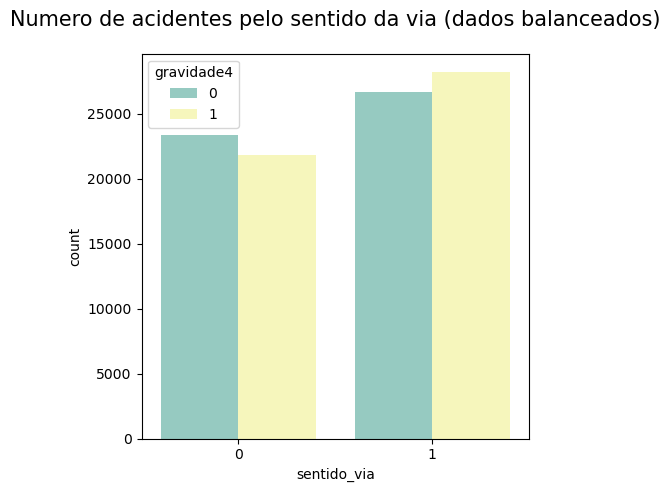

In [23]:
plt.figure(figsize=(5,5))
chart = sns.countplot(x='sentido_via', hue='gravidade4', data=df_prf_balanceado_ordenado ,palette="Set3")
plt.title("Numero de acidentes pelo sentido da via (dados balanceados)", size=15, y=1.05)
plt.show()

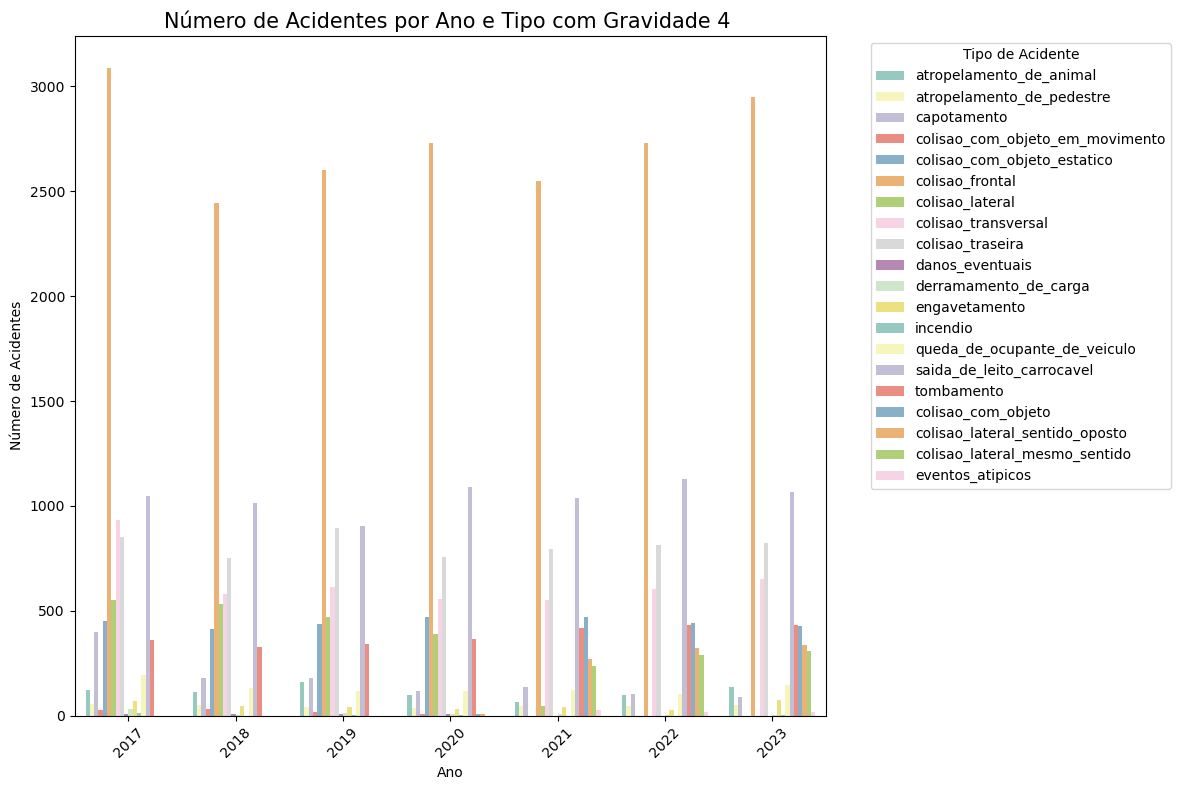

In [24]:
# Contar o número de acidentes por Ano e Tipo de Acidente
tipo_acidentes_por_ano = df_prf_balanceado_ordenado[df_prf_balanceado_ordenado['gravidade4'] == 1].groupby(['Ano', 'tipo_acidente']).size().reset_index(name='count')


plt.figure(figsize=(12, 8))

sns.barplot(data=tipo_acidentes_por_ano, x='Ano', y='count', hue='tipo_acidente', palette='Set3')

plt.gca().set_xlabel('Ano')
plt.gca().set_ylabel('Número de Acidentes')

plt.title('Número de Acidentes por Ano e Tipo com Gravidade 4 ', size=15)
plt.xticks(rotation=45)
plt.legend(title='Tipo de Acidente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


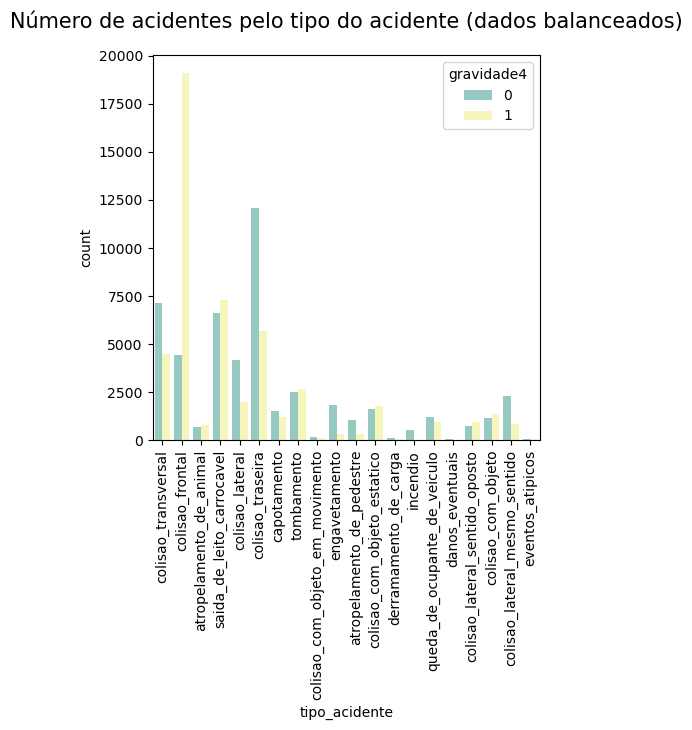

In [25]:
plt.figure(figsize=(5, 5))
chart = sns.countplot(x='tipo_acidente', hue='gravidade4', data=df_prf_balanceado_ordenado, palette="Set3")
plt.title("Número de acidentes pelo tipo do acidente (dados balanceados)", size=15, y=1.05)

plt.xticks(rotation=90)

plt.show()


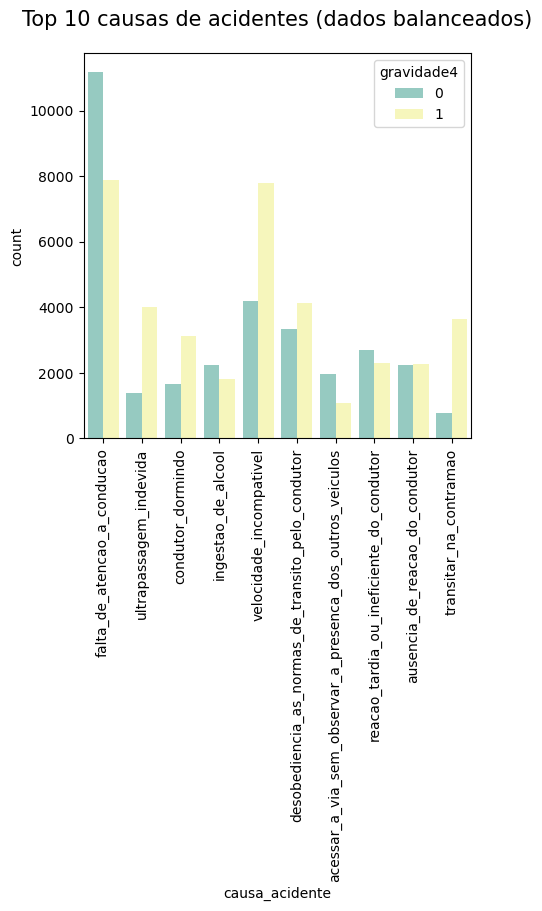

In [26]:
top_10_causas = df_prf_balanceado_ordenado['causa_acidente'].value_counts().head(10).index
df_top10_causas = df_prf_balanceado_ordenado[df_prf_balanceado_ordenado['causa_acidente'].isin(top_10_causas)]

plt.figure(figsize=(5, 5))
chart = sns.countplot(x='causa_acidente', hue='gravidade4', data=df_top10_causas, palette="Set3")
plt.title("Top 10 causas de acidentes (dados balanceados)", size=15, y=1.05)

plt.xticks(rotation=90)

plt.show()


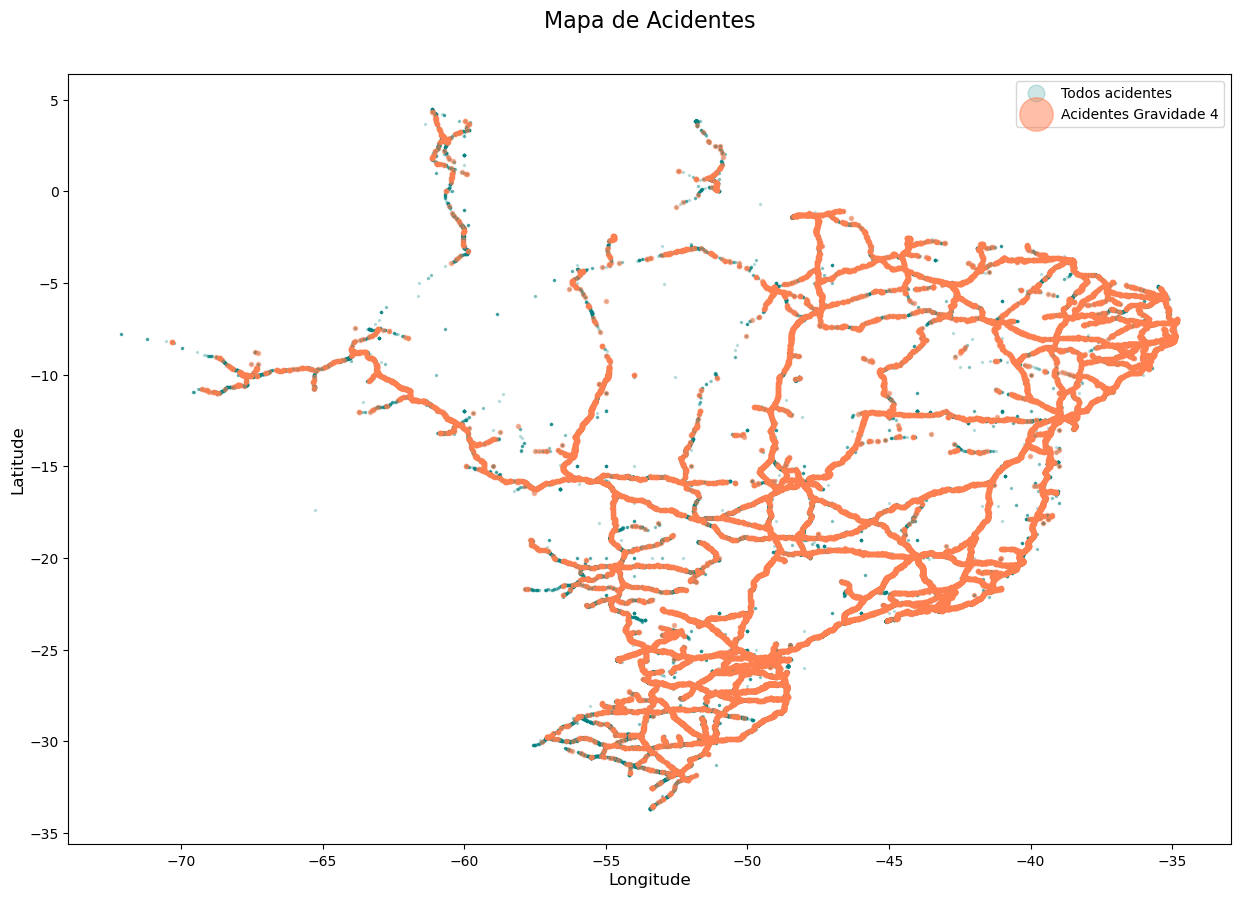

In [27]:
df_4 = df_prf[df_prf['gravidade4']==1]
df_normal = df_prf

plt.figure(figsize=(15,10))

plt.plot( 'longitude', 'latitude', data=df_normal, linestyle='', marker='o', markersize=1.5, color="teal", alpha=0.2, label='Todos acidentes')
plt.plot( 'longitude', 'latitude', data=df_4, linestyle='', marker='o', markersize=3, color="coral", alpha=0.5, label='Acidentes Gravidade 4')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Mapa de Acidentes', size=16, y=1.05)
plt.show()

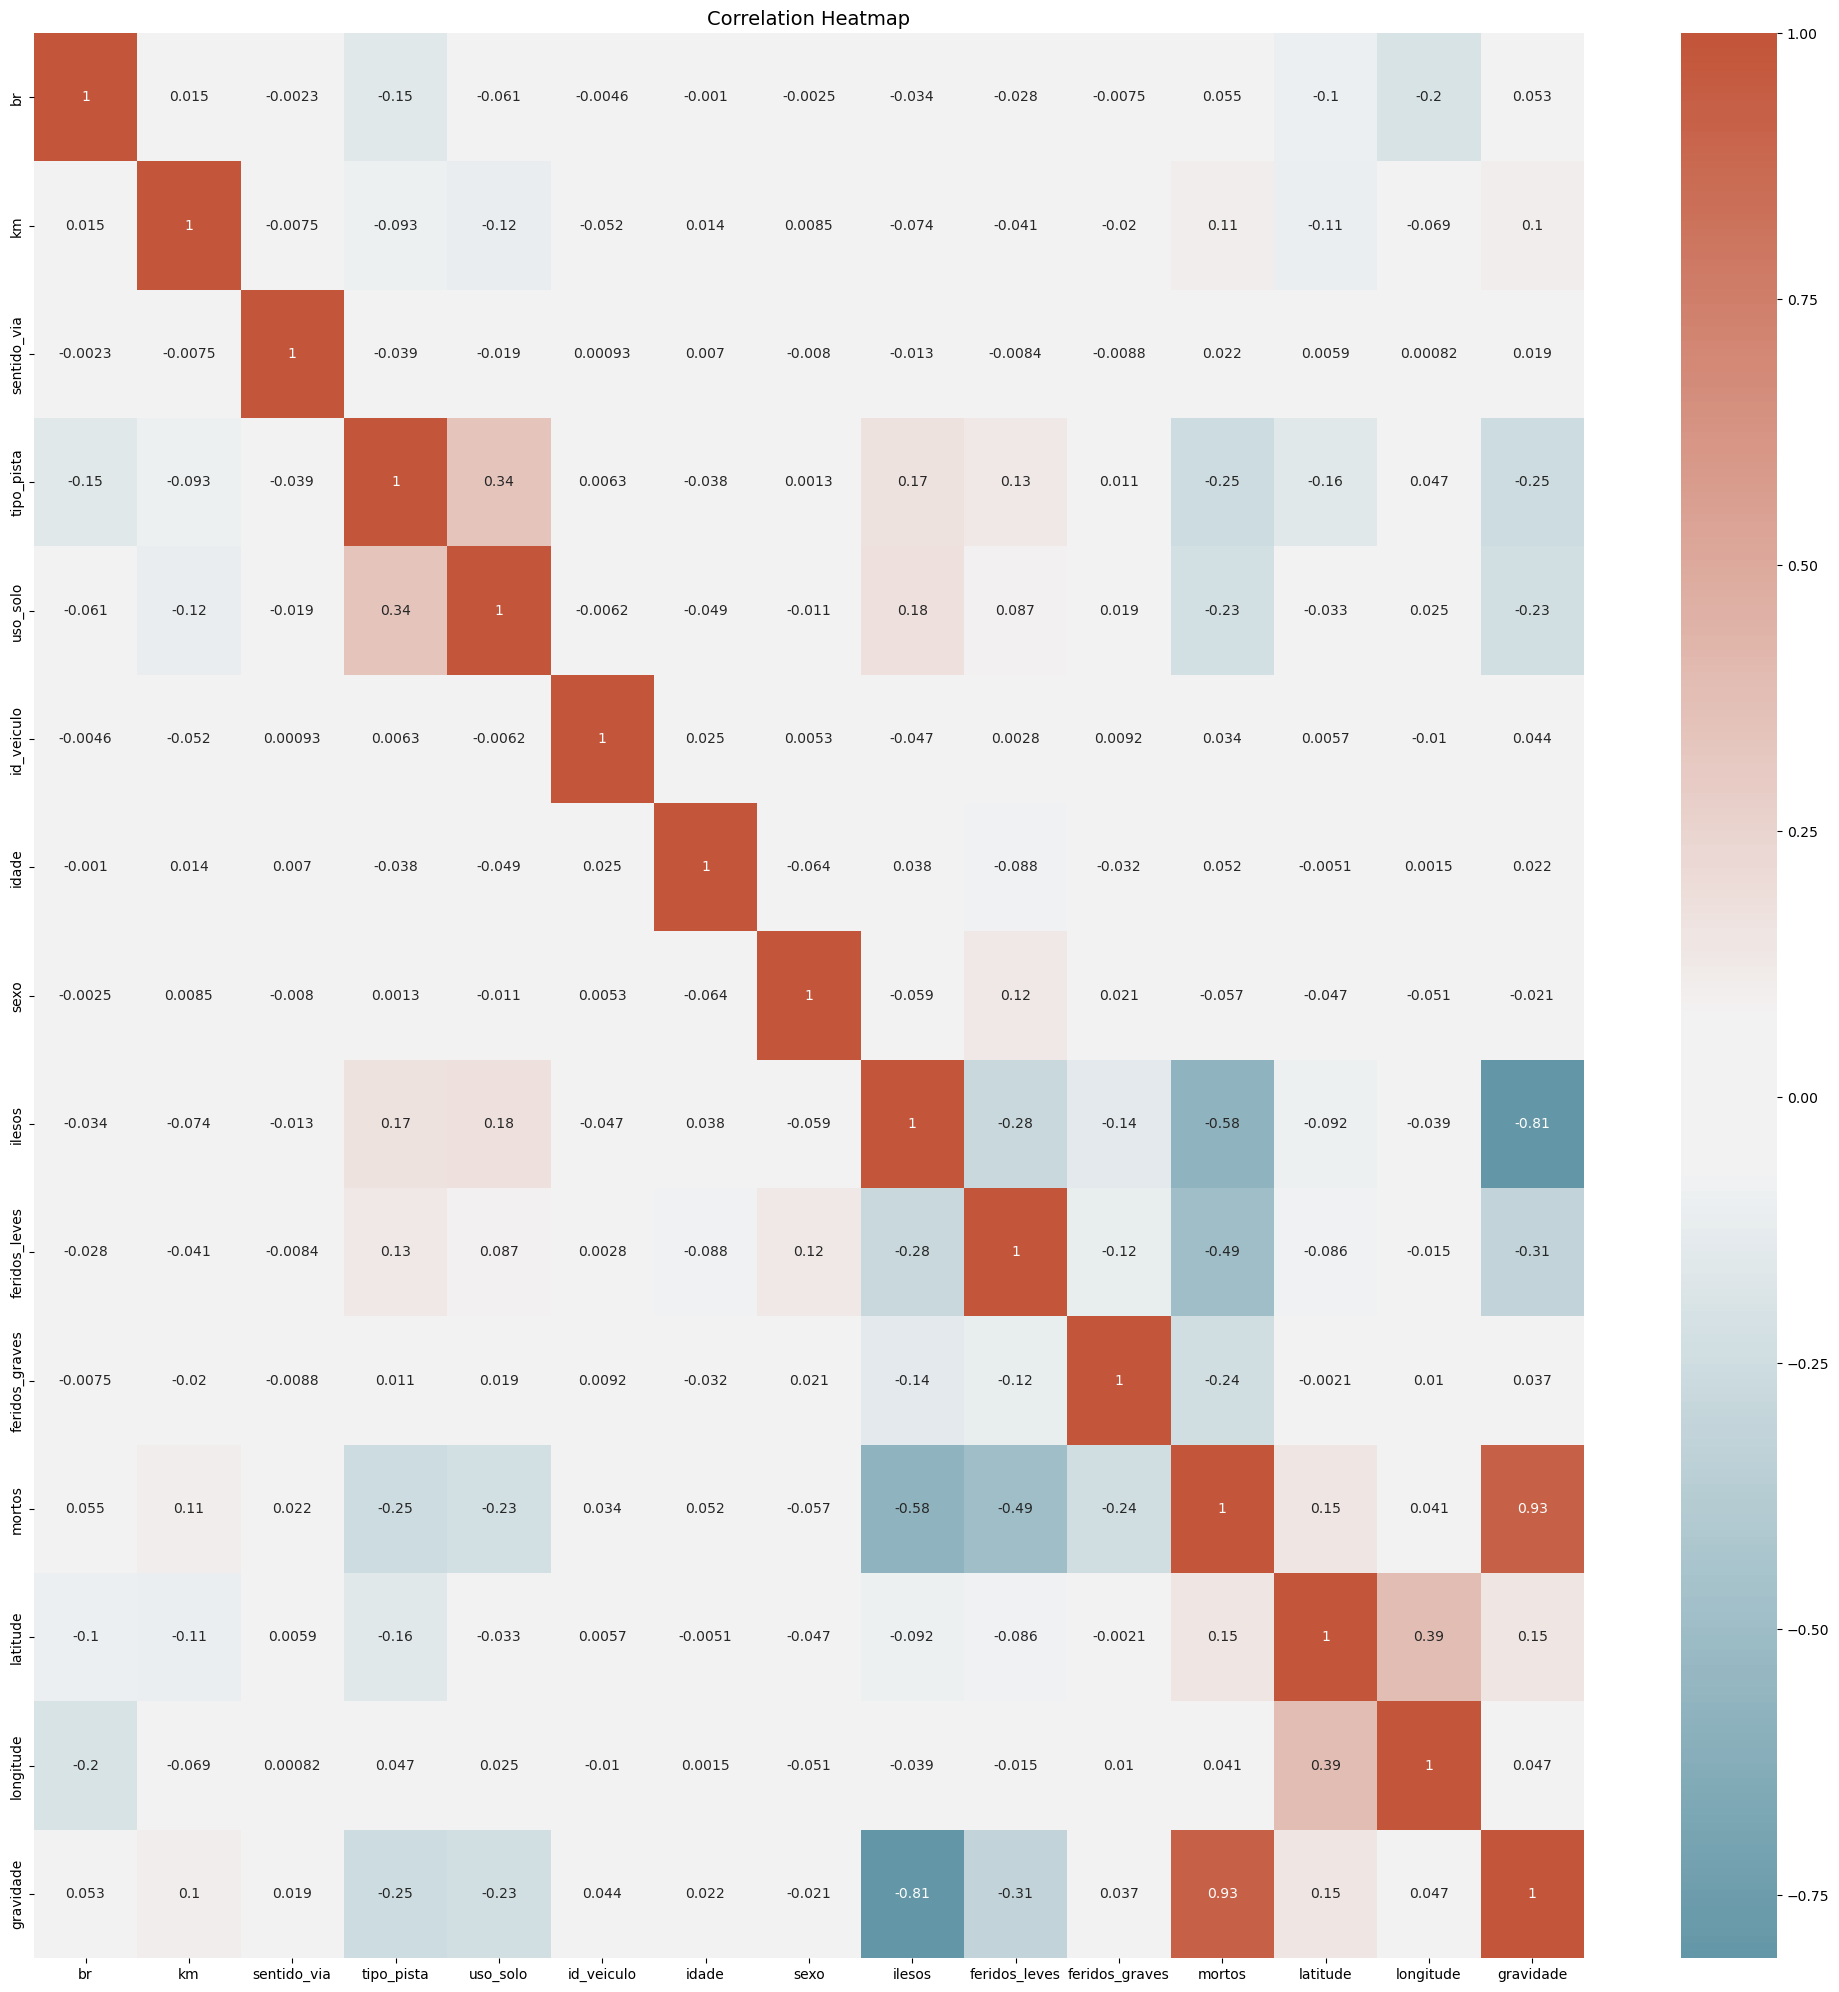

In [28]:
df_correlacao = resample(df_prf, 'gravidade4', 20000)

df_correlacao['gravidade4'] = df_correlacao['gravidade4'].astype(int)
df_numeric = df_correlacao.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(25,25))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_numeric.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=14)
plt.show()

### One Hot Encoding

In [29]:
colunas_para_remover = ["gravidade4", "estado_fisico", "mortos", "feridos_graves", "feridos_leves", "ilesos", "dia_semana", "data_inversa", "horario", "municipio", "classificacao_acidente", "fase_dia", "id_veiculo", "tipo_envolvido"]
colunas_para_one_hot = ["causa_acidente", "tipo_acidente", "tipo_veiculo", "tracado_via"]
tipo_veiculos_para_remover = ['bicicleta', 'carroca_charrete', 'chassi_plataforma', 'ciclomotor',
 'micro_onibus', 'onibus', 'motor_casa', 'outros', 'reboque', 'semireboque',
 'trator_de_rodas', 'trator_misto', 'trem_bonde', 'triciclo', 'utilitario',]
# colunas_one_hot2 = ["marca_veiculo", "modelo_veiculo", "uf"]

In [30]:
df_to_one_hot = df_prf.copy()

df_to_one_hot = df_to_one_hot.drop(colunas_para_remover, axis=1)
df_to_one_hot = df_to_one_hot[~df_to_one_hot['tipo_veiculo'].isin(tipo_veiculos_para_remover)]

In [31]:
df_to_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 919401 entries, 0 to 977883
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   uf                      919401 non-null  object        
 1   br                      919401 non-null  int64         
 2   km                      919401 non-null  float64       
 3   causa_acidente          919401 non-null  object        
 4   tipo_acidente           919401 non-null  object        
 5   sentido_via             919401 non-null  int64         
 6   tipo_pista              919401 non-null  int64         
 7   tracado_via             919401 non-null  object        
 8   uso_solo                919401 non-null  int64         
 9   tipo_veiculo            919401 non-null  object        
 10  marca                   919401 non-null  object        
 11  ano_fabricacao_veiculo  919401 non-null  int32         
 12  idade                   919401 non-

In [32]:
df_prf_one_hot = df_to_one_hot

# variáveis condição climática, anteriormente colocadas como booleanas, agora transformadas em variáveis binarias 0 | 1
df_prf_one_hot = df_prf_one_hot.replace([True, False], [1,0])
# ["dia_semana", "uf", "sentido_via", "tipo_acidente", "tipo_pista", "uso_solo", "sexo", "fase_dia", "tracado_via", "tipo_veiculo"]
# variáveis categóricas para one-hot
col_categoricas = colunas_para_one_hot

C:\Users\Rayron\AppData\Local\Temp\ipykernel_10508\151726919.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prf_one_hot = df_prf_one_hot.replace([True, False], [1,0])


In [33]:
cat_encoder = OneHotEncoder(sparse_output=False)

models_1hot = cat_encoder.fit_transform(df_prf_one_hot[col_categoricas]) # Aplicar o encoder nas colunas categóricas
encoded_cols = cat_encoder.get_feature_names_out(col_categoricas) # Verificar as colunas geradas pelo encoder

encoded_df = pd.DataFrame(models_1hot, columns=encoded_cols, index=df_prf_one_hot.index)

df_encoded = pd.concat([df_prf_one_hot.drop(columns=col_categoricas), encoded_df], axis=1)

df_encoded

,uf,br,km,sentido_via,tipo_pista,uso_solo,marca,ano_fabricacao_veiculo,idade,sexo,...,tracado_via_viaduto_rotatoria,tracado_via_viaduto_rotatoria_curva_em_obras,tracado_via_viaduto_rotatoria_curva_intersecao_de_vias,tracado_via_viaduto_rotatoria_intersecao_de_vias,tracado_via_viaduto_rotatoria_intersecao_de_vias_em_obras,tracado_via_viaduto_rotatoria_reta,tracado_via_viaduto_rotatoria_reta_declive,tracado_via_viaduto_rotatoria_retorno_regulamentado_intersecao_de_vias,tracado_via_viaduto_tunel_curva_intersecao_de_vias,tracado_via_viaduto_tunel_intersecao_de_vias_reta_declive_rotatoria
0,RS,116,349.0,0,1,0,vw_17_280_crm_4x2_4p,2014,31,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PR,376,636.0,1,2,0,m_benz_atego_2430,2014,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BA,101,65.0,0,1,0,scania_g_380_a4x2,2009,53,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,RN,405,30.0,1,1,0,scania_r_480_a6x4,2013,44,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PR,376,2495.0,1,1,0,ford_cargo_1723,2014,56,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977879,PR,369,1586.0,1,2,1,honda_cbx_250_twister,2006,34,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977880,PR,369,1586.0,1,2,1,honda_cbx_250_twister,2006,41,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977881,MG,116,413.0,0,1,1,honda_cg_160_fan,2018,25,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977882,MG,116,413.0,0,1,1,honda_cg_160_fan,2018,41,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Regressao Logistica

In [34]:
df_logistic_regression = df_encoded.copy()

df_logistic_regression = df_encoded.select_dtypes(include=['float64', 'int64', 'int32'])

# split X, y
X_lr = df_logistic_regression.drop('gravidade', axis=1)
y_lr = df_logistic_regression['gravidade']

scaler_lr = StandardScaler()
X_scaled_lr = scaler_lr.fit_transform(X_lr)

# split train, test
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_scaled_lr, y_lr, test_size=0.3, random_state=42)

In [35]:
model_lr = LogisticRegression(max_iter=4000)  # Ajuste 'max_iter' para garantir a convergência
model_lr.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=4000)

In [36]:
y_pred_lr = model_lr.predict(X_test_lr)

In [37]:
print(accuracy_score(y_test_lr, y_pred_lr))

0.6490513775238289


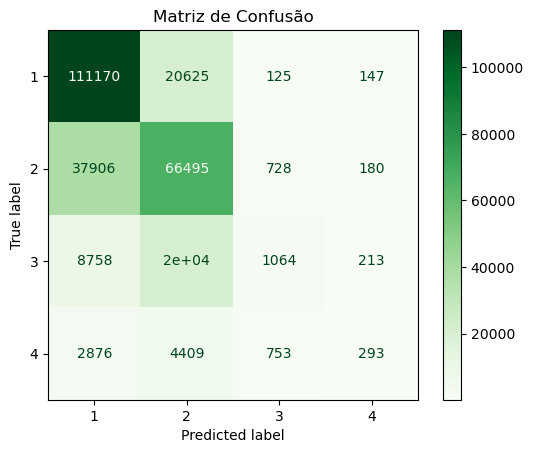

In [38]:
confusion_matrix_lr = confusion_matrix(y_test_lr, y_pred_lr)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr, display_labels=model_lr.classes_)
disp_lr.plot(cmap='Greens')
plt.title("Matriz de Confusão")
plt.show()

#Classe Negativa (Verdadeiro Negativo - VN)	VN	FP (Falso Positivo)
#Classe Positiva (Falso Negativo - FN)	FN	VP (Verdadeiro Positivo)

# Verdadeiros Positivos (VP): Casos corretamente classificados como positivos.
# Verdadeiros Negativos (VN): Casos corretamente classificados como negativos.
# Falsos Positivos (FP): Casos negativos classificados erroneamente como positivos (tipo I).
# Falsos Negativos (FN): Casos positivos classificados erroneamente como negativos (tipo II).


In [39]:
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           1       0.69      0.84      0.76    132067
           2       0.60      0.63      0.61    105309
           3       0.40      0.04      0.06     30114
           4       0.35      0.04      0.06      8331

    accuracy                           0.65    275821
   macro avg       0.51      0.39      0.38    275821
weighted avg       0.61      0.65      0.61    275821



In [ ]:
# Obter as probabilidades previstas
y_prob_lr = model_lr.predict_proba(X_test_lr)[:, 1]  # Pegue as probabilidades da classe positiva

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_lr, y_prob_lr)

# Calcular o AUC
auc = roc_auc_score(y_test_lr, y_prob_lr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Modelo Aleatório (AUC = 0.5)")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Interpretação do Gráfico
# Curva mais próxima do canto superior esquerdo:

# Indica um modelo com melhor capacidade de separação entre as classes.
# AUC próximo de 1:

# Significa que o modelo tem excelente desempenho.
# AUC próximo de 0.5:

# Indica que o modelo não tem poder discriminativo (equivalente ao chute aleatório).
# Avaliação prática:

# Se o AUC é alto, mas o modelo ainda comete muitos erros, verifique os dados (desbalanceamento, qualidade) ou ajuste o limiar de decisão.

## floresta


In [40]:
df_rf = df_encoded.select_dtypes(include=['float64', 'int64', 'int32'])

# split X, y
X_rf = df_rf.drop('gravidade', axis=1)
y_rf = df_rf['gravidade']

# scaler_rf = StandardScaler()
# X_scaled_rf = scaler_rf.fit_transform(X_rf)

# split train, test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

In [41]:
rf = RandomForestClassifier(
    n_estimators=100,  # Número de árvores na floresta
    max_depth=None,    # Profundidade máxima das árvores
    random_state=42,   # Para resultados reprodutíveis
    class_weight='balanced'  # Ajusta peso das classes automaticamente
)

In [42]:
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [43]:
y_pred_rf = rf.predict(X_test_rf)

Matriz de Confusão:


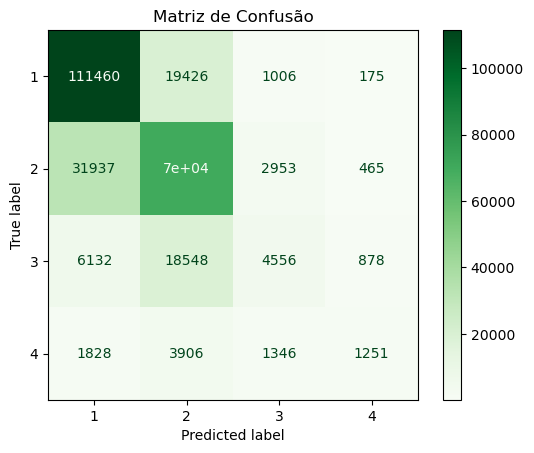

In [44]:
print("Matriz de Confusão:")

confusion_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=rf.classes_)
disp_rf.plot(cmap='Greens')
plt.title("Matriz de Confusão")
plt.show()

In [45]:
print("\nRelatório de Classificação:")
print(classification_report(y_test_rf, y_pred_rf))


Relatório de Classificação:
              precision    recall  f1-score   support

           1       0.74      0.84      0.79    132067
           2       0.63      0.66      0.64    105309
           3       0.46      0.15      0.23     30114
           4       0.45      0.15      0.23      8331

    accuracy                           0.68    275821
   macro avg       0.57      0.45      0.47    275821
weighted avg       0.66      0.68      0.65    275821



In [46]:
importances = rf.feature_importances_
for feature, importance in zip(X_rf.columns, importances):
    print(f"{feature}: {importance:.4f}")

br: 0.0443
km: 0.0569
sentido_via: 0.0150
tipo_pista: 0.0174
uso_solo: 0.0148
ano_fabricacao_veiculo: 0.0557
idade: 0.0862
sexo: 0.0169
latitude: 0.0596
longitude: 0.0567
Céu Claro: 0.0105
Garoa/Chuvisco: 0.0033
Nublado: 0.0082
Sol: 0.0047
Chuva: 0.0062
Nevoeiro/Neblina: 0.0013
Vento: 0.0004
Granizo: 0.0000
Neve: 0.0000
Ano: 0.0333
Mes: 0.0428
Dia: 0.0494
Hora: 0.0506
Minuto: 0.0422
Dia da Semana: 0.0363
causa_acidente_acessar_a_via_sem_observar_a_presenca_dos_outros_veiculos: 0.0025
causa_acidente_acesso_irregular: 0.0007
causa_acidente_acostamento_em_desnivel: 0.0002
causa_acidente_acumulo_de_agua_sobre_o_pavimento: 0.0005
causa_acidente_acumulo_de_areia_ou_detritos_sobre_o_pavimento: 0.0002
causa_acidente_acumulo_de_oleo_sobre_o_pavimento: 0.0001
causa_acidente_afundamento_ou_ondulacao_no_pavimento: 0.0002
causa_acidente_agressao_externa: 0.0003
causa_acidente_animais_na_pista: 0.0016
causa_acidente_area_urbana_sem_a_presenca_de_local_apropriado_para_a_travessia_de_pedestres: 0.0000

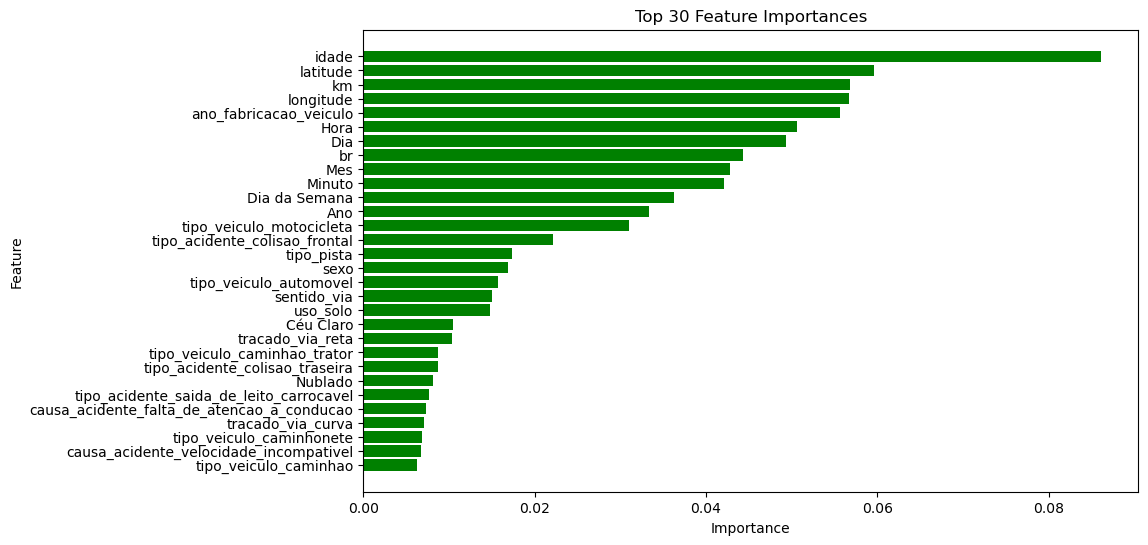

In [47]:
# Converter o array bidimensional para unidimensional
importances = importances.ravel()

# Criar um DataFrame com as features e suas importâncias
importances_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': importances
})

# Filtrar apenas as features com importância maior que zero
importances_df = importances_df[importances_df['Importance'] > 0]

# Ordenar as features pela importância (do maior para o menor)
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Selecionar as 10 maiores importâncias
top_10_importances = importances_df.head(30)

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_10_importances['Feature'], top_10_importances['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Inverter o eixo Y para ter as maiores importâncias no topo
plt.show()

### Rede Neural

In [48]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
colunas_importanes = [
    "idade",
    "latitude",
    "km",
    "longitude",
    "ano_fabricacao_veiculo",
    "Hora",
    "Dia",
    "br",
    "Mes",
    "Minuto",
    "Dia da Semana",
    "Ano",
    "tipo_veiculo_motocicleta",
    "tipo_acidente_colisao_frontal",
    "tipo_pista",
    "sexo",
    "tipo_veiculo_automovel",
    "sentido_via",
    "uso_solo",
    "Céu Claro",
    "tracado_via_reta",
    "tipo_veiculo_caminhao_trator",
    "tipo_acidente_colisao_traseira",
    "Nublado",
    "tipo_acidente_saida_de_leito_carrocavel",
    "causa_acidente_falta_de_atencao_a_conducao",
    "tracado_via_curva",
    "tipo_veiculo_caminhonete",
    "causa_acidente_velocidade_incompativel",
    "tipo_veiculo_caminhao",
    "gravidade"
]

In [50]:
# 1. Carregar os dados
# Substitua 'seu_dataset.csv' pelo caminho para o seu arquivo
df_rna = df_encoded.copy()
#df_rna = df_rna[colunas_importanes]
df_rna = df_encoded.select_dtypes(include=['float64', 'int64', 'int32'])


In [51]:
# Suponha que 'target' é a coluna de rótulos e o restante são as features
X_rna = df_rna.drop('gravidade', axis=1)  # Features
y_rna = df_rna['gravidade']              # Classe

In [52]:
# 2. Pré-processamento dos dados
# Dividir o conjunto em treino e teste
X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(X_rna, y_rna, test_size=0.3, random_state=42)

In [53]:
# Normalizar as features (padrão necessário para redes neurais)
scaler_rna = StandardScaler()
X_train_rna = scaler_rna.fit_transform(X_train_rna)
X_test_rna = scaler_rna.transform(X_test_rna)

In [54]:
# Se o problema for de classificação com múltiplas classes, fazer one-hot encoding
num_classes_rna = len(np.unique(y_rna))  # Número de classes

# Ajustar os rótulos para começar de 0 (se necessário)
y_train_rna = y_train_rna - y_train_rna.min()
y_test_rna = y_test_rna - y_test_rna.min()

y_train_rna = to_categorical(y_train_rna, num_classes_rna)
y_test_rna = to_categorical(y_test_rna, num_classes_rna)

In [55]:
# 3. Construir a rede neural
model_rna = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_rna.shape[1],)),  # Camada oculta com 64 neurônios
    Dense(32, activation='relu'),                                  # Camada oculta com 32 neurônios
    Dense(num_classes_rna, activation='softmax' if num_classes_rna > 2 else 'sigmoid')  # Camada de saída
])

c:\Users\Rayron\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
# 4. Compilar o modelo
model_rna.compile(
    optimizer='adam',                      # Otimizador eficiente
    loss='categorical_crossentropy' if num_classes_rna > 2 else 'binary_crossentropy',  # Função de perda
    metrics=['accuracy']                   # Métrica de avaliação
)

In [57]:
# 5. Treinar o modelo
history = model_rna.fit(
    X_train_rna, y_train_rna,
    epochs=50,                # Número de épocas
    batch_size=32,            # Tamanho do lote
    validation_split=0.2,     # Usar 20% do treino para validação
    verbose=1                 # Mostrar progresso
)

Epoch 1/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.6410 - loss: 0.8673 - val_accuracy: 0.6538 - val_loss: 0.8328
Epoch 2/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6569 - loss: 0.8271 - val_accuracy: 0.6590 - val_loss: 0.8252
Epoch 3/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6588 - loss: 0.8224 - val_accuracy: 0.6580 - val_loss: 0.8226
Epoch 4/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6606 - loss: 0.8194 - val_accuracy: 0.6590 - val_loss: 0.8268
Epoch 5/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6614 - loss: 0.8169 - val_accuracy: 0.6595 - val_loss: 0.8224
Epoch 6/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6619 - loss: 0.8137 - val_accuracy: 0.6596 - val_loss: 0.8220
Epoch 7/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.6612 - loss: 0.8144 - val_accuracy: 0.6600 - val_loss: 0.8212
Epoch 8/50
16090/16090 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 

In [58]:
# 6. Avaliar o modelo
loss_rna, accuracy_rna = model_rna.evaluate(X_test_rna, y_test_rna)
print(f"\nLoss: {loss_rna:.4f}, Accuracy: {accuracy_rna:.4f}")

8620/8620 ━━━━━━━━━━━━━━━━━━━━ 7s 825us/step - accuracy: 0.6596 - loss: 0.8247

Loss: 0.8274, Accuracy: 0.6577


In [59]:
# Fazer previsões
y_pred_rna = model_rna.predict(X_test_rna)
if num_classes_rna > 2:
    y_pred_classes_rna = np.argmax(y_pred_rna, axis=1)  # Converter para rótulos de classe
    y_true_classes_rna = np.argmax(y_test_rna, axis=1)
else:
    y_pred_classes_rna = (y_pred_rna > 0.5).astype(int).flatten()
    y_true_classes_rna = y_test_rna

8620/8620 ━━━━━━━━━━━━━━━━━━━━ 5s 596us/step


In [60]:
# 7. Métricas de desempenho
print("\nMatriz de Confusão:")
print(confusion_matrix(y_true_classes_rna, y_pred_classes_rna))


Matriz de Confusão:
[[107261  24373    192    241]
 [ 31764  71703   1262    580]
 [  6814  20935   1435    930]
 [  1969   4650    707   1005]]


In [61]:
print("\nRelatório de Classificação:")
print(classification_report(y_true_classes_rna, y_pred_classes_rna))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77    132067
           1       0.59      0.68      0.63    105309
           2       0.40      0.05      0.09     30114
           3       0.36      0.12      0.18      8331

    accuracy                           0.66    275821
   macro avg       0.52      0.42      0.42    275821
weighted avg       0.63      0.66      0.62    275821

